In [21]:
import lasio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prov import identifier

In [23]:
DATA_DIR = "..\\data\\las"
EXCEL_DIR = "..\\data"

In [15]:
well_idx = []

In [16]:
for filename in os.listdir(DATA_DIR):
    # Print each filename
    well_idx.append(filename.split("_")[0])
    # print(filename)

In [18]:
well_idx = set(well_idx)

In [19]:
len(well_idx)

41

In [65]:
type(list(well_idx)[0])

str

In [26]:
excel = pd.read_excel(EXCEL_DIR + "\\Отбивки пласта АС11-2.xlsx")

In [45]:
upper_bounds = excel.iloc[::2].copy()
upper_bounds.rename(columns={'Z': 'upper'}, inplace=True)
upper_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [50]:
lower_bounds = excel.iloc[1::2].copy()
lower_bounds.rename(columns={'Z': 'lower'}, inplace=True)
lower_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [66]:
target_layers = pd.merge(upper_bounds, lower_bounds, on='Well identifier', how='outer')
target_layers['Well identifier'] = target_layers['Well identifier'].astype(str)
target_layers = target_layers[target_layers['Well identifier'].isin(well_idx)]


In [69]:
target_layers

,Well identifier,upper,lower
1,12,-2161.95,-2183.98
2,13,-2158.72,-2175.36
3,14,-2170.38,-2190.59
4,15,-2170.84,-2188.69
5,16,-2157.70,-2178.94
6,17,-2150.80,-2171.09
7,18,-2146.87,-2167.39
8,19,-2129.24,-2150.87
9,20,-2141.56,-2162.04
10,22,-2129.92,-2146.85


In [75]:
SELECTED_WELL = '12'

In [84]:
def view_well(selected_well, target_layers=target_layers):
    las = lasio.read(os.path.join(DATA_DIR, f"{selected_well}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.loc[target_layers['Well identifier'] == selected_well].upper.values) & (las['Z'] > target_layers.loc[target_layers['Well identifier'] == selected_well].lower.values))
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(las["DEPT"][target_layer_idx], las["NEU"][target_layer_idx])
    plt.xlabel("Depth")
    plt.ylabel("NEU")
    plt.subplot(122)
    plt.plot(las["DEPT"][target_layer_idx], las["GGKP"][target_layer_idx])
    plt.xlabel("Depth")
    plt.ylabel("GGKP")
    plt.show()

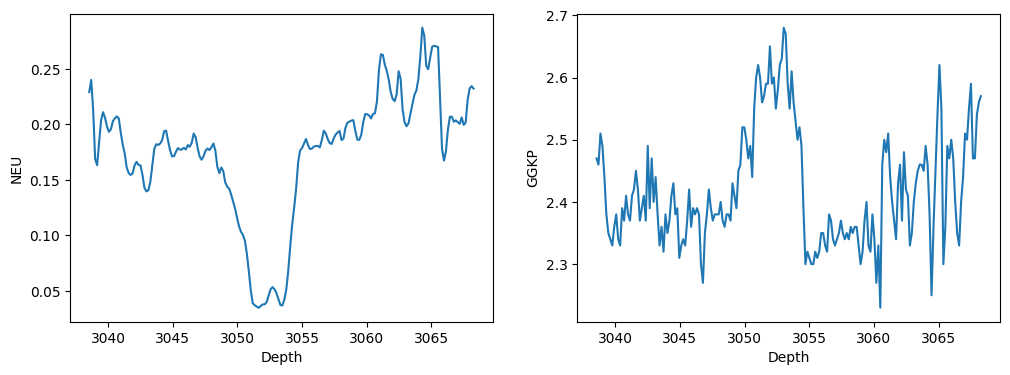

In [85]:
view_well(SELECTED_WELL)

мысль - свёртки

depth - длина по стволу - по кривой
sstvd - абсолютная переведённая
z - от моря
одна положительная другая отрицательная разницы нет
лучше либо 2 либо 3

ggkp - гамма каротаж - фоновое гамма излучение

отбивки - границы пласта(субгоризонтальная бурная порода) - точка входа и выхода из целевого пласта - остальное неинтересно
Z - тот же столбик
MD - глубина

дискретные файлы
facies - ручная разметка вручную
log9 - обонзачает то же самое, просто укрупленная, достаточно одной
когда пересекаем глубину начинается код N


neu - нейтронный каротаж - неважно? можно по одной, но с этой +



суть задачи

- кластеризация всех скважин в пределах пластов по форме гамма и второго каротажа
- дальше сложнее: кластеризация кусков формы внутри пласта. То есть каждый график разбить на кусочки - берутся из дискретности. Не
- - Не всегда размечены именно формы, какой-то информации у нас может не быть
- - Цель - не 100% совпадение с разметкой ручной
- - Скользящее окно не дало плодов, проблемы - шум, интересуют крупные, на каждую скважину не более 3

отобразить, посмотреть, обрезать по пласту, поискать основные формы, описаны в какой-тио методике - простейшие геометрические - коробки, пирамиды, воронки
по второй - сложно непонятно